In [51]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [52]:
cifar_train = datasets.CIFAR10('data', train=True, download=True, transform=transforms.ToTensor())
cifar_test = datasets.CIFAR10('data', train=False, download=True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [53]:
x_train = cifar_train.data
y_train = np.array(cifar_train.targets)
x_test = cifar_test.data
y_test = np.array(cifar_test.targets)

x_train = x_train.astype(np.float32)/255.
x_test = x_test.astype(np.float32)/255.
# x_train = x_train.reshape(x_train.shape[0], -1)
# x_test = x_test.reshape(x_test.shape[0], -1)

print(f"x_train.shape", x_train.shape)
print(f"y_train.shape", y_train.shape)
print(f"x_test.shape", x_test.shape)
print(f"y_test.shape", y_test.shape)

x_train.shape (50000, 32, 32, 3)
y_train.shape (50000,)
x_test.shape (10000, 32, 32, 3)
y_test.shape (10000,)


In [54]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'trunk']

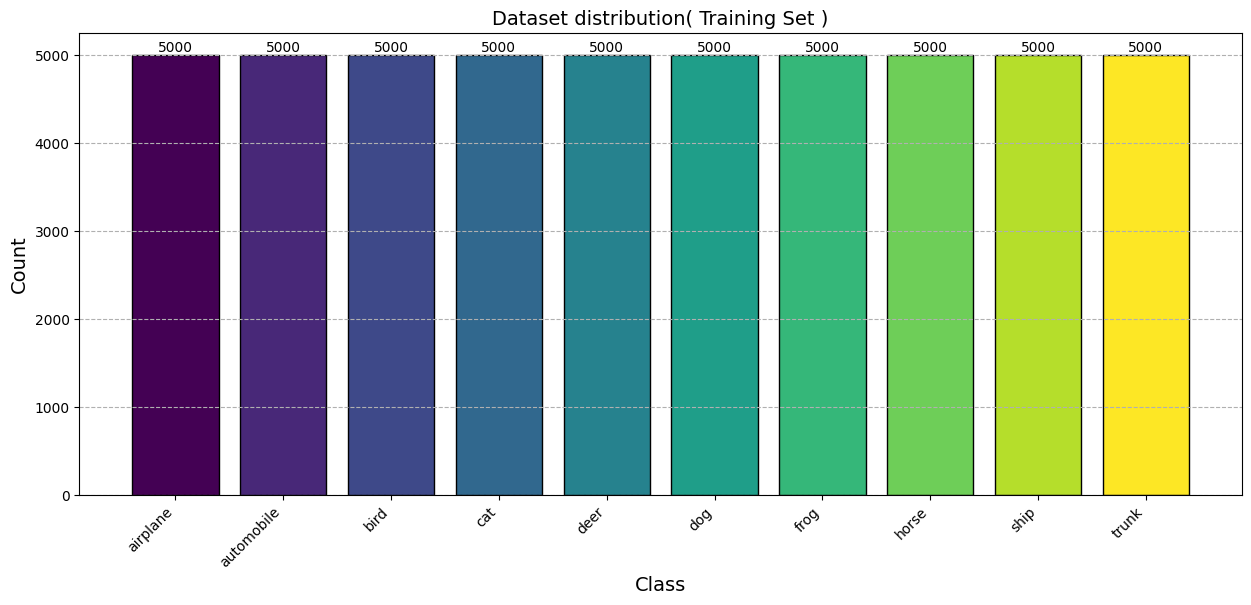

In [55]:
plt.figure(figsize=(15,6))

counts = np.bincount(y_train)
x_pos = np.arange(len(classes))
bars = plt.bar(x_pos, counts, align='center', color=plt.cm.viridis(np.linspace(0,1,len(classes))), edgecolor='black')

plt.xticks(x_pos, classes, rotation=45, ha='right')
plt.title('Dataset distribution( Training Set )', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xlabel('Class', fontsize=14)
plt.grid(axis='y', linestyle='--')

for bar in bars:
  hight = bar.get_height()
  plt.text(bar.get_x() + bar.get_width() / 2., hight, f'{hight}', ha='center', va='bottom')

plt.show()

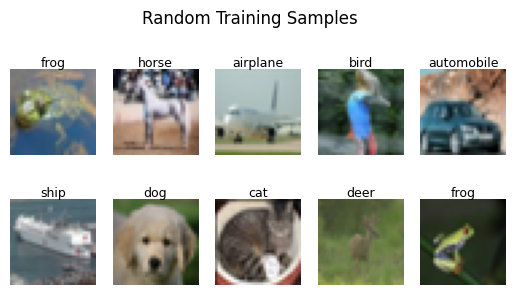

In [56]:
def visualize_data(images, labels, classes, num_display=10):
  plt.figure()
  indices = np.random.choice(len(images), num_display)

  for i, idx in enumerate(indices):
      plt.subplot(3, 5, i+1)
      plt.imshow(images[idx])
      plt.title(classes[labels[idx]], fontsize=9, pad=2)
      plt.axis('off')

  plt.suptitle('Random Training Samples')
  plt.show()
visualize_data(x_train, y_train, classes)

In [61]:
X_train = x_train.reshape(x_train.shape[0], -1)
X_test = x_test.reshape(x_test.shape[0], -1)

#add L2 normalization
def l2_norm(features):
  l2_norms = np.linalg.norm(features, axis=1, keepdims=True) + 1e-8
  features = features / l2_norms
  return features

X_train = l2_norm(X_train)
X_test = l2_norm(X_test)

#add PCA
pca = PCA(n_components=0.99, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print(f"X_train.shape", X_train.shape)
print(f"X_train_pca.shape", X_train_pca.shape)

print(f"X_test.shape", X_test.shape)

X_train.shape (50000, 3072)
X_train_pca.shape (50000, 781)
X_test.shape (10000, 3072)


In [62]:
def compute_disdance(x1, x2):
  distance = np.sqrt(np.mean(np.abs((x1-x2)**2)))
  return distance

class NearestNeighborClassifier:
  def __init__(self, X, y, metric='euclidean'):
    self.X_train = X
    self.y_train = y
    self.metric = metric

  def predict(self, X_test):
    predictions = []
    if self.metric == 'euclidean':
      distances = np.array([[compute_disdance(x, t) for t in self.X_train] for x in tqdm(X_test)])
      nearest_neighbor = np.argmin(distances, axis=1)
      #predictions.extend(self.y_train[nearst_neighbor])
    elif self.metric == 'cosine':
      similarities = np.dot(X_test, self.X_train.T)
      nearest_neighbor = np.argmax(similarities, axis=1)
    predictions.extend(self.y_train[nearest_neighbor])

    return np.array(predictions)

def visualize_predictions(images, labels_true, labels_pred, classes, num_display=10):
  plt.figure(figsize=(16, 6))
  indices = np.random.choice(len(images), num_display, replace=False)
  for i, idx in enumerate(indices):
    plt.subplot(3, 5, i+1)
    plt.imshow(images[idx])
    plt.title(f'True: {classes[labels_true[idx]]}\nPred: {classes[labels_pred[idx]]}', fontsize=9, pad=2)
    plt.axis('off')
  plt.suptitle('Visualized results')
  plt.show()

In [ ]:
nn = NearestNeighborClassifier(X_train_pca, y_train, metric='euclidean')

test_num = 100
y_pred = nn.predict(X_test_pca[:test_num])

accuracy = np.mean(y_pred == y_test[:test_num])
print(f"Accuracy: {accuracy*100:.2f}%")

visualize_predictions(x_test[:test_num], y_test[:test_num], y_pred, classes)